<center><h1>Business Intelligence and Visualization Project - Bike Sharing Company </h1>
<h2>By: Wiebke Plückhahn</h2>
<h3>Date: 12/22/2022</h3></center>

In this fictitious case study, a bike sharing company from Chicago wants to understand **how riders with an active membership status differ in their renting behavior compared to casually riding people without a membership subsrciption**. Also, some general advice is appreciated.

Data analyzed is the divvy tripdata (available at https://divvy-tripdata.s3.amazonaws.com/index.html). Monthly data from between August 2021 and July 2022 was downloaded and provided via the GCP Cloud Storage and BigQuery Service. The data analyzed comprises almost 6 million rides. All 12 datasets were combined in BigQuery using a SQL union statement. No further data wrangling has taken place before, all data preparation will tke place in this notebook.

In order to make general recommendations and to answer the particular question, all data is first submitted to a sanity check and afterwards analyzed with different statistical methods, like Mann-Whitney-U-test, Kruskal-Wallis-test, and Pearson's Chi Quare test. Relationships are then visualized using different techniques, including geospatial plotting.

In [1]:
#Set up working environment
%pip install pandasql
%pip install researchpy
%pip install folium==0.5.0
import folium
from google.cloud.bigquery import Client, QueryJobConfig
import numpy as np
import researchpy as rp
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
from pandasql import sqldf
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import pylab 
pysqldf=lambda q:sqldf(q, globals())

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing data from BigQuery and providing a brief summary
#Note: This Notebook was originally hosted on Google Cloud Vertex AI Workbench
client = Client()
query = """SELECT * FROM `flowing-access-365407.data2020.complete21-22` """
job = client.query(query)
df = job.to_dataframe()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5901463 entries, 0 to 5901462
Data columns (total 13 columns):
 #   Column              Dtype              
---  ------              -----              
 0   ride_id             object             
 1   rideable_type       object             
 2   started_at          datetime64[ns, UTC]
 3   ended_at            datetime64[ns, UTC]
 4   start_station_name  object             
 5   start_station_id    object             
 6   end_station_name    object             
 7   end_station_id      object             
 8   start_lat           float64            
 9   start_lng           float64            
 10  end_lat             float64            
 11  end_lng             float64            
 12  member_casual       object             
dtypes: datetime64[ns, UTC](2), float64(4), object(7)
memory usage: 585.3+ MB


ride_id  rideable_type                started_at  \
0  E5A1BFF51EA756C2  electric_bike 2022-07-03 15:44:07+00:00   
1  1E373F1BD866271C  electric_bike 2021-10-10 18:59:43+00:00   
2  A54D606AC1CEA7A0  electric_bike 2021-08-13 17:10:07+00:00   
3  86FF6A9414412563  electric_bike 2022-01-05 12:18:27+00:00   
4  F7A435013644F529  electric_bike 2022-05-09 19:23:38+00:00   

                   ended_at start_station_name start_station_id  \
0 2022-07-03 15:57:38+00:00               None             None   
1 2021-10-10 19:04:42+00:00               None             None   
2 2021-08-13 17:15:21+00:00               None             None   
3 2022-01-05 13:05:14+00:00               None             None   
4 2022-05-09 19:31:52+00:00               None             None   

  end_station_name end_station_id  start_lat  start_lng  end_lat  end_lng  \
0             None           None      41.98     -87.65     42.0   -87.66   
1             None           None      41.99     -87.68     42.0   -87.68   
2             None           None      41.99     -87.69     42.0   -87.69   
3             None           None      42.00     -87.68     42.0   -87.68   
4             None           None      42.02     -87.71     42.0   -87.71   

  member_casual  
0        casual  
1        casual  
2        member  
3        casual  
4        casual

In [3]:
#Next, some time wrangling is applied.
#First, the ride length is computed. 
df['ride_length'] = df['ended_at'] - df['started_at']
df['ride_length_min']=df.ride_length.dt.total_seconds()/60 #ride lengths in minutes

#Then, variables containing the month, weekday, and time of day in hour of each rent are computed.
df['hour'] = df['started_at'].dt.hour
df['weekday'] = df['started_at'].dt.dayofweek #0 means monday
df['month'] = df['started_at'].dt.month 

<h2>Sanity checks: Data preparation and exploration</h2>
<h3>Missing values</h3>
The sanity check performed first tests for missing datapoints in the dataset.

In [4]:
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    860786
start_station_id      860784
end_station_name      919896
end_station_id        919896
start_lat                  0
start_lng                  0
end_lat                 5590
end_lng                 5590
member_casual              0
ride_length                0
ride_length_min            0
hour                       0
weekday                    0
month                      0
dtype: int64

Besides start and end station names and id, end latitude and longitude, there are no missings in the data frame. This is not a problem at all, as all data will be analyzed per start of rents considering the geographic coordinates. Also, as data will be plotted in a map, the names of stations will not be of interest. The same applies for station IDs.

<h3>Outlier detection</h3>
Next, outliers will be detected (and replaced by mean imputation or excluded from the dataset).
<h4>Categorical variables</h4>

member    3379237
casual    2522226
Name: member_casual, dtype: int64

<AxesSubplot:>

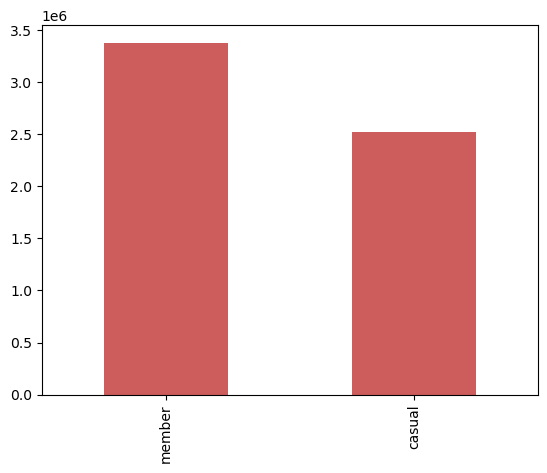

In [5]:
#Membership status
display(df['member_casual'].value_counts())
df['member_casual'].value_counts().plot(kind='bar', color='indianred')

Apparently, there are more member than casual riders. But the database is rich enough to perform analyses of differences between both groups.

classic_bike     3055641
electric_bike    2619094
docked_bike       226728
Name: rideable_type, dtype: int64

<AxesSubplot:>

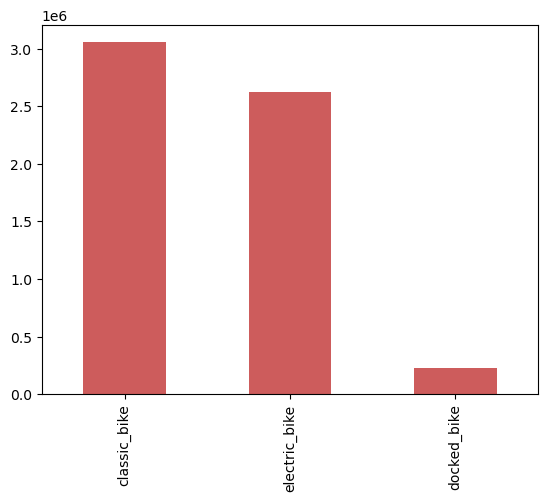

In [6]:
#Bike type
display(df['rideable_type'].value_counts())
df['rideable_type'].value_counts().plot(kind='bar', color='indianred')

Assuming that the company offers more classic bikes than electric or docked bikes for rent, the distribution is not surprising. And all data of docked bikes remains in the dataset.

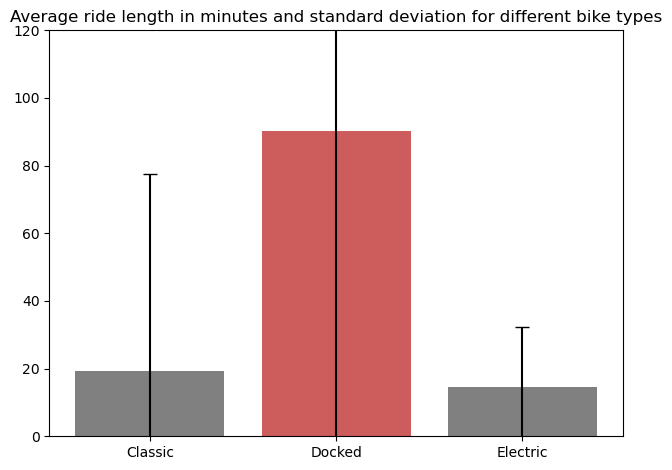

In [7]:
df_m=df[['rideable_type', 'ride_length_min']].groupby(['rideable_type']).mean()
df_s=df[['rideable_type', 'ride_length_min']].groupby(['rideable_type']).std()

# Create lists for the plot
bikes = ['Classic', 'Docked', 'Electric']
x_pos = np.arange(len(bikes))
Ms = [df_m.iat[0,0], df_m.iat[1,0], df_m.iat[2,0]]
error = [df_s.iat[0,0], df_s.iat[1,0], df_s.iat[2,0]]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, Ms, yerr=error, align='center', ecolor='black', capsize=5, color=['grey', 'indianred', 'grey'])
ax.set_xticks(x_pos)
ax.set_xticklabels(bikes)
ax.set_ylim([0,120])
plt.title('Average ride length in minutes and standard deviation for different bike types')
plt.tight_layout()
plt.show()

On average, rented dock bikes are ridden the longest.

<h4>Continuous variables - Location</h4>
In langitude and latitude of the start station, there seem to be some unusual values which will next be excluded from further analyses. Therefore, all data points will be plotted in a map first. The folium package is used here.

In [8]:
#Create a map of centered around the US
rent_map = folium.Map(location=[39.74, -104.99], zoom_start=4, tiles='CartoDB positron')

#As the dataset is too large for folium to process, all latitudes and longitudes are rounded with 3 decimal places 
#and then grouped to shorten the df. The datapoints are then plotted and weighted by their occurency to account for
#geospatial accumulations in different locations.
df['round_start_lat']=round(df['start_lat'],3)
df['round_start_lng']=round(df['start_lng'],3)
df_map=df[['round_start_lat', 'round_start_lng','ride_length_min']].groupby(by=['round_start_lat', 'round_start_lng']).count()
df_map.rename(columns={'ride_length_min':'frequency'}, inplace=True)
df_map.reset_index(inplace=True)

#Initiate a feature group for the rents in the dataframe
rents = folium.map.FeatureGroup()

#Loop through the rents and add each to the rents feature group
for lat, lng, size in zip(df_map.round_start_lat, df_map.round_start_lng, df_map.frequency):
    rents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=size/4000,
            color='indianred',
            fill=True,
            fill_color='indianred',
            fill_opacity=0.7
        )
    )

#Add rents to map
rent_map.add_child(rents)

The map mainly shows rents in Chicago, and a few in Montreal. As climate, rent policies, marketing, and customer base, etc. might be different in Canada, this analysis will focus on the Chicago region.
The following boxplots show the distribution of start latitudes and longitudes before and after the removal of cases outside of the Chicago region.

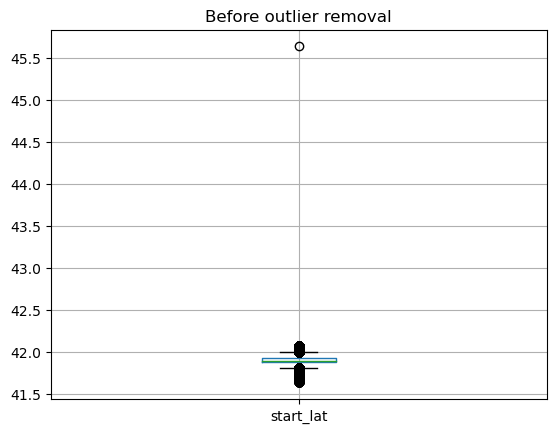

Text(0.5, 1.0, 'After outlier removal')

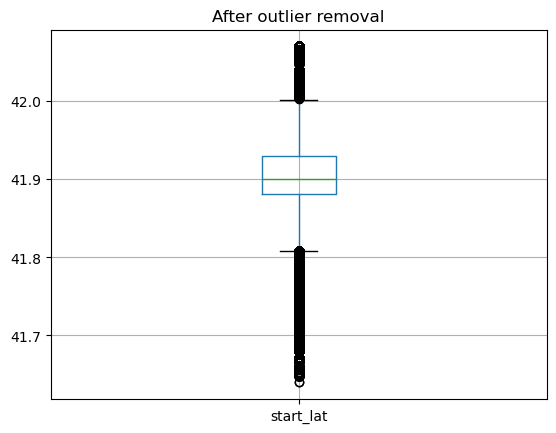

In [9]:
df.boxplot(column="start_lat")
plt.title('Before outlier removal')
plt.show()
df.drop(df[df.start_lat > 42.5].index, inplace=True)
df.boxplot(column="start_lat")
plt.title('After outlier removal')

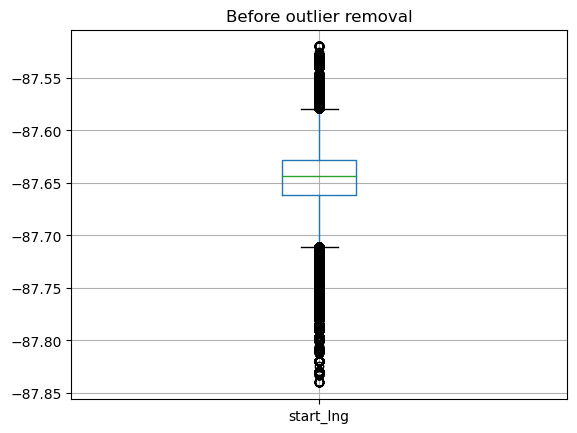

Text(0.5, 1.0, 'After outlier removal')

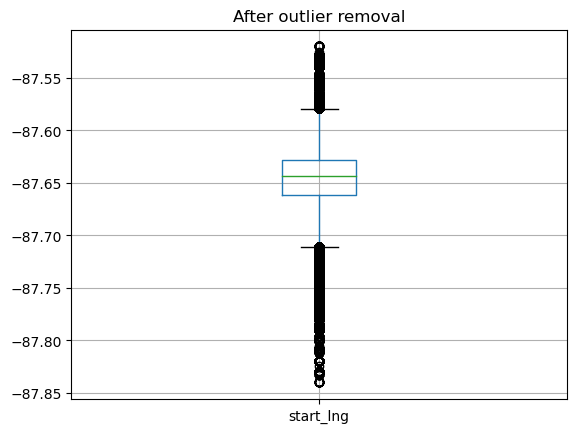

In [10]:
df.boxplot(column="start_lng")
plt.title('Before outlier removal')
plt.show()
df.drop(df[df.start_lng > -86].index, inplace=True)
df.boxplot(column="start_lng")
plt.title('After outlier removal')

<h4>Continuous variables - Time</h4>
Next, all variables containing time measures are examined as follows:

- Ride length
- Month
- Weekday
- Time of day

In [11]:
#Ride length
print("All rides were between", df.ride_length_min.min(), "minutes and",df.ride_length_min.max()/60/24, "days long.")

All rides were between -137.41666666666666 minutes and 28.90914351851852 days long.


This variable clearly holds some errors. Negative values will be replaced by mean imputation.
However, long-term rentals are not necessarily a data error, so they are left in the data set. Nevertheless, to control for a possible bias, a quartile split is applied, dividing the data set into long-term and short-term rentals, so that more differentiated findings are possible. The cut-offs are set to the 25th and 75th quartile.

In [12]:
m = df.ride_length_min.mean()
df['ride_length_min'].mask(df['ride_length_min'] < 0, m, inplace=True)
quart = df['ride_length_min'].quantile([.25, .5, .75])
display(quart)
df['short_rides']=df['ride_length_min']
df['short_rides'].mask(df['short_rides'] > quart[0.25], inplace=True)
df['medium_rides']=df['ride_length_min']
df['medium_rides'].mask(df['medium_rides'] > quart[0.75], inplace=True)
df['medium_rides'].mask(df['medium_rides'] < quart[0.25], inplace=True)
df['long_rides']=df['ride_length_min']
df['long_rides'].mask(df['long_rides'] < quart[0.75], inplace=True)

0.25     6.166667
0.50    10.950000
0.75    19.816667
Name: ride_length_min, dtype: float64

50% of the ride lengths are 6 to 20 minutes long. Thus, this time span will be used to generate insights into the usual rents. Rents shorter than 6 minutes are considered ultra short term rents, rents longer than 20 minutes will be considered long term rents.

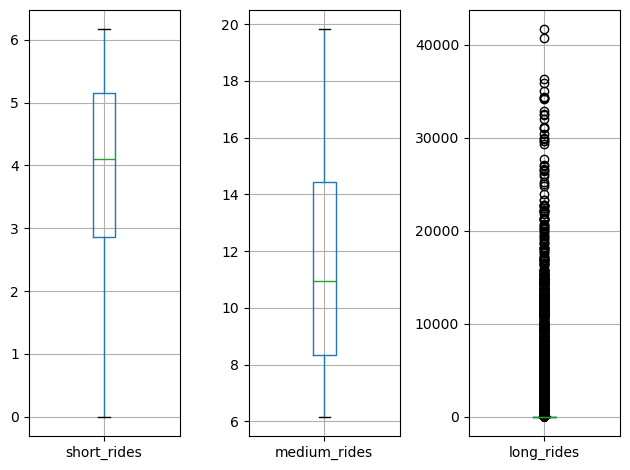

In [13]:
fig = plt.figure()
ax0 = fig.add_subplot(131)
df.boxplot(column="short_rides", ax=ax0)
ax1 = fig.add_subplot(132)
df.boxplot(column="medium_rides", ax=ax1)
ax2 = fig.add_subplot(133)
df.boxplot(column="long_rides", ax=ax2)
fig.tight_layout()
plt.show()

The boxplot show no outliers for short and medium rides. Long rental periods show many extreme values. Nevertheless, these are left in the data because, as stated above, the long rental periods are quite plausible and could even be in the company's interest. Lastly, the three subcategories and overall ride length are checked for normal distribution to determine further statistical tests.

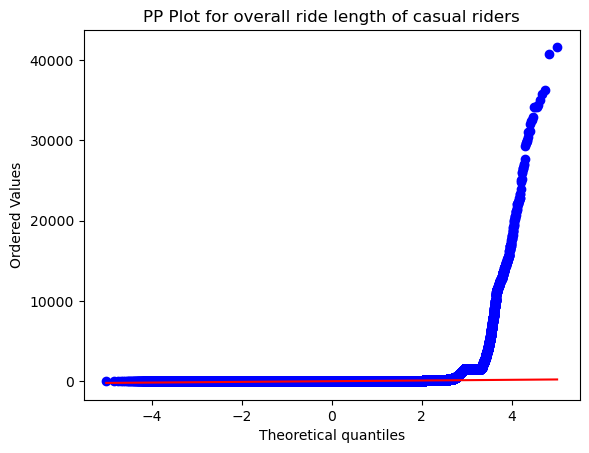

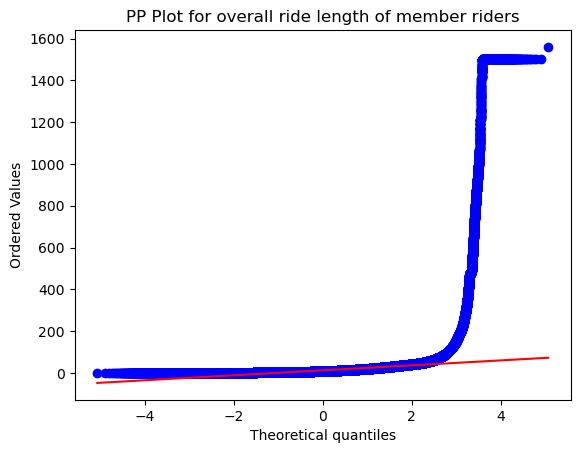

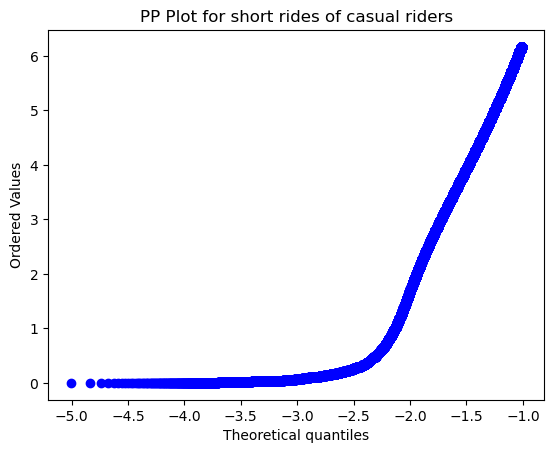

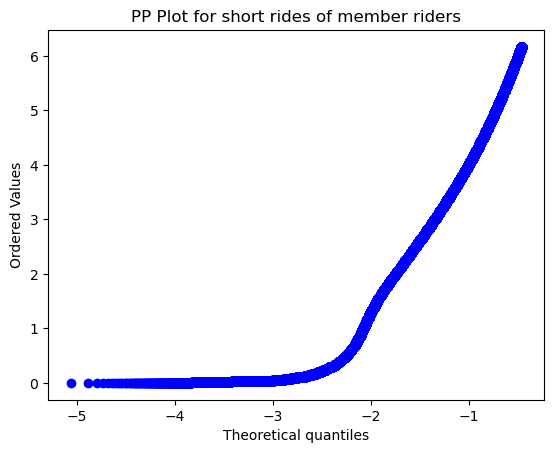

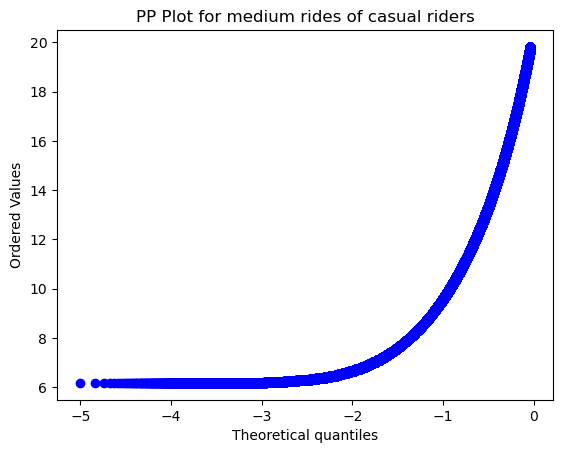

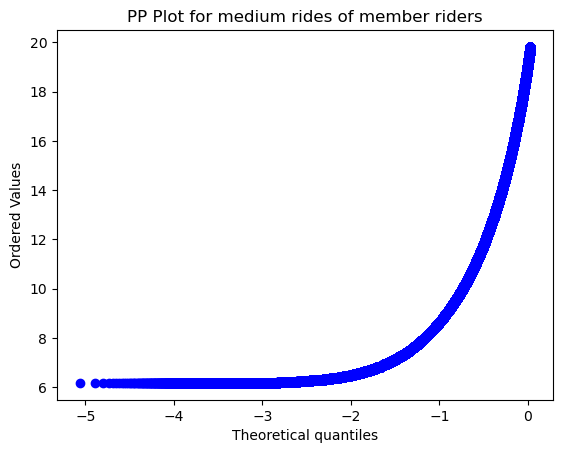

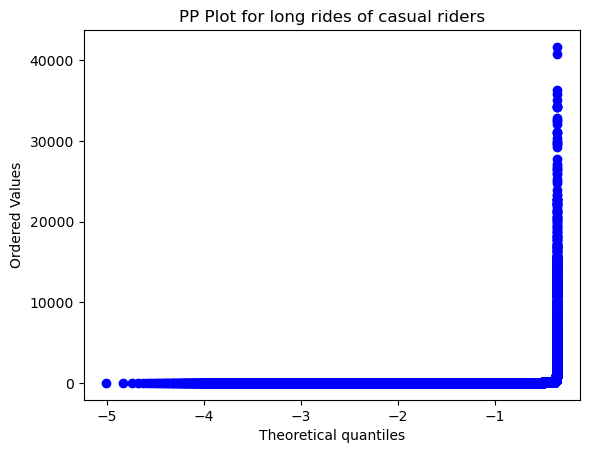

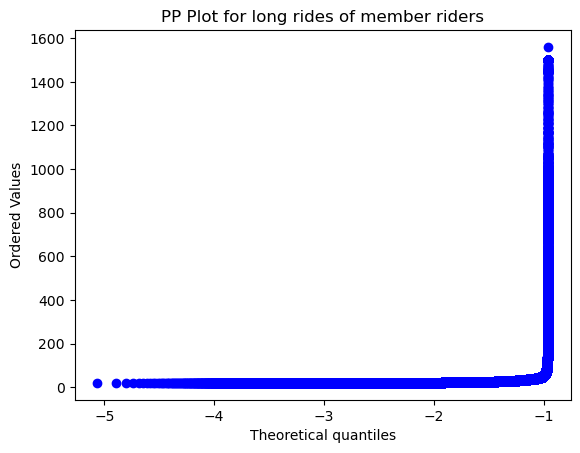

In [14]:
stats.probplot(df['ride_length_min'][df['member_casual'] == 'casual'], dist="norm", plot=pylab)
plt.title('PP Plot for overall ride length of casual riders')
pylab.show()

stats.probplot(df['ride_length_min'][df['member_casual'] == 'member'], dist="norm", plot=pylab)
plt.title('PP Plot for overall ride length of member riders')
pylab.show()

stats.probplot(df['short_rides'][df['member_casual'] == 'casual'], dist="norm", plot=pylab)
plt.title('PP Plot for short rides of casual riders')
pylab.show()

stats.probplot(df['short_rides'][df['member_casual'] == 'member'], dist="norm", plot=pylab)
plt.title('PP Plot for short rides of member riders')
pylab.show()

stats.probplot(df['medium_rides'][df['member_casual'] == 'casual'], dist="norm", plot=pylab)
plt.title('PP Plot for medium rides of casual riders')
pylab.show()

stats.probplot(df['medium_rides'][df['member_casual'] == 'member'], dist="norm", plot=pylab)
plt.title('PP Plot for medium rides of member riders')
pylab.show()

stats.probplot(df['long_rides'][df['member_casual'] == 'casual'], dist="norm", plot=pylab)
plt.title('PP Plot for long rides of casual riders')
pylab.show()

stats.probplot(df['long_rides'][df['member_casual'] == 'member'], dist="norm", plot=pylab)
plt.title('PP Plot for long rides of member riders')
pylab.show()

All four variables are not normally distributed, neither in the member nor in the casual group. Therefore, nonparametric tests are performed in the analysis section.

<h5>Month, weekday, and time of day</h5>

All timestamps lie between 2021-08-01 00:00:04+00:00 and 2022-07-31 23:59:58+00:00


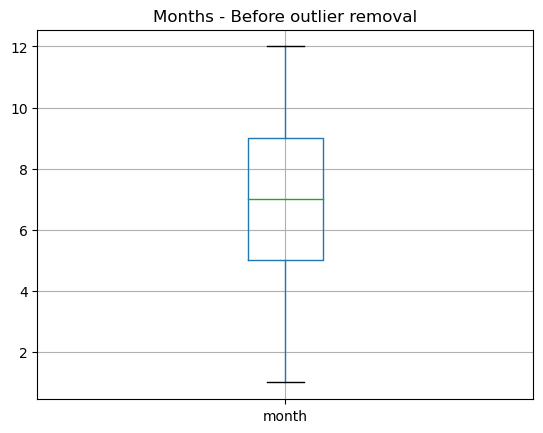

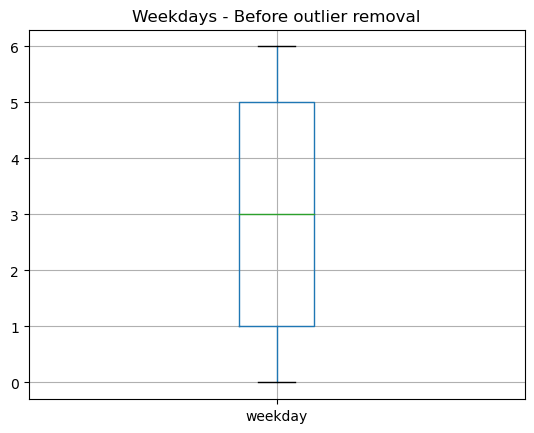

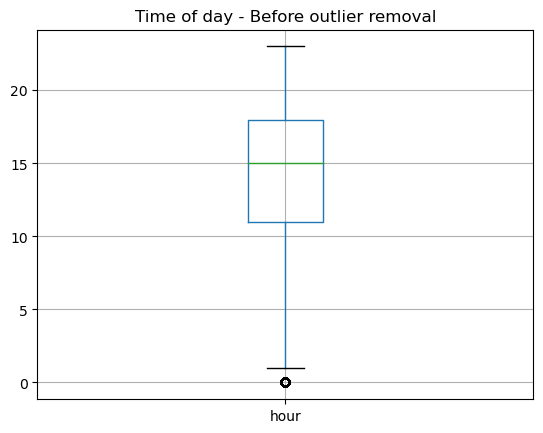

In [15]:
#Month
print("All timestamps lie between", df.started_at.min(), "and",df.started_at.max())
df.boxplot(column="month")
plt.title('Months - Before outlier removal')
plt.show()
df.boxplot(column="weekday")
plt.title('Weekdays - Before outlier removal')
plt.show()
df.boxplot(column="hour")
plt.title('Time of day - Before outlier removal')
plt.show()

All month, weekday and hour codes seem to be computed correctly (see correlation matrix under Exploratory Analysis for further confirmation) and lie within the correct time span.

<h3>Exploratory Analysis</h3>
As location, bike types, and membership status were examined above, the additional exploratory analysis will investigate riding times, and times of rentals. Furthermore, a correlation table and headmap are provided, depicting relationships of all variables in the dataset.

<AxesSubplot:>

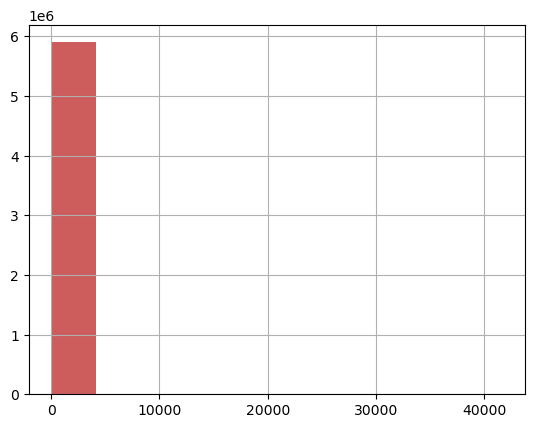

In [16]:
#Ride length
df['ride_length_min'].hist(color='indianred')

Most rides were considerably short. This fits the quartile analysis above.

<AxesSubplot:xlabel='month'>

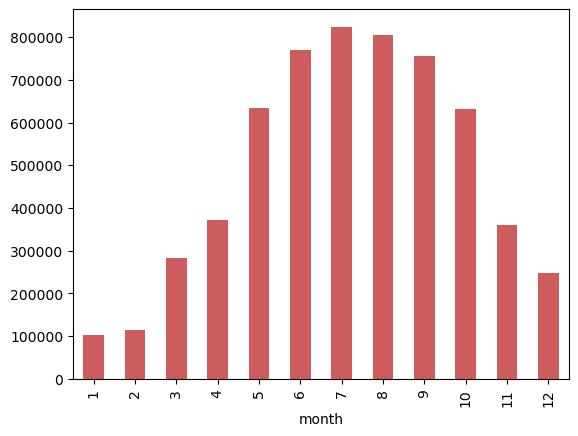

In [17]:
df_vg = df[['month', 'ride_id']].groupby(by='month').count().reset_index()
df_vg.plot(x='month', kind='bar', color='indianred', legend=False)

This very quick first impression shows that customers rode bikes fairly more often during sommer months.

<AxesSubplot:xlabel='weekday'>

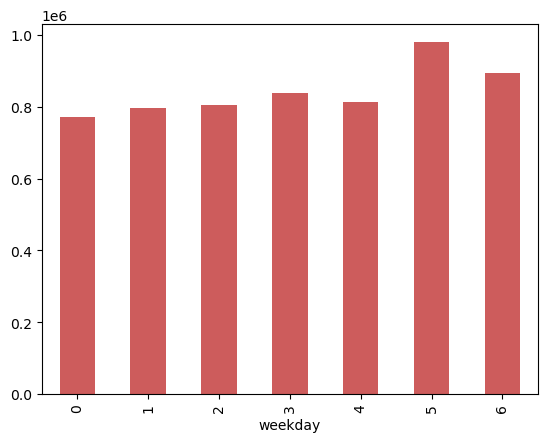

In [18]:
df_vg = df[['weekday', 'ride_id']].groupby(by='weekday').count().reset_index()
df_vg.plot(x='weekday', kind='bar', color='indianred', legend=False)

There are slitghtly more rides on weekends, most rides are on Saturdays (0 means Monday).

<AxesSubplot:xlabel='hour'>

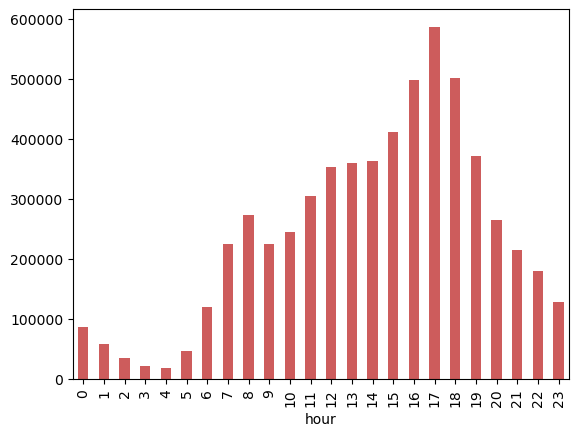

In [19]:
df_vg = df[['hour', 'ride_id']].groupby(by='hour').count().reset_index()
df_vg.plot(x='hour', kind='bar', color='indianred', legend=False)

As could be expected, rentals are peaking at rush hour time (4 to 6pm). Consequently, **bike maintanance** should take place in the morning.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


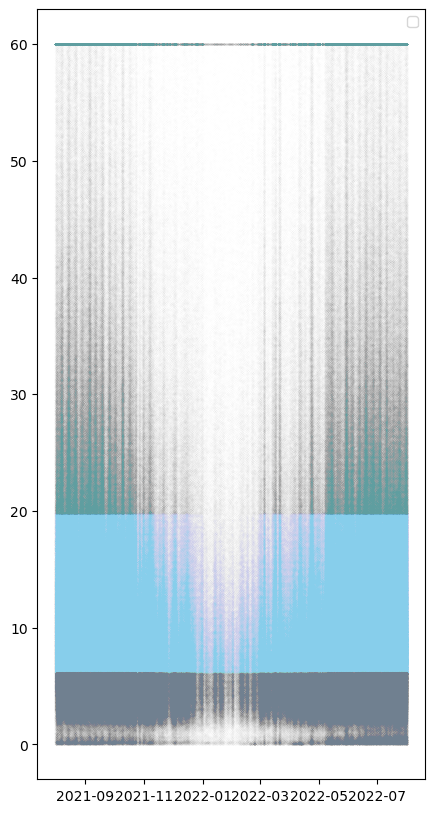

In [20]:
#The long rides variable will distort the shape of the plot. 
#Therefore, all rents longer than an hour will be set to 60 minutes for this visualization
warnings.filterwarnings("ignore")
df1=df[['started_at', 'long_rides']]
df1['long_rides'].mask(df1['long_rides'] >60, 60, inplace=True)

#Building scatter plot
fig, ax = plt.subplots()
fig.set_size_inches(5,10)
ax.scatter(df['started_at'], df['short_rides'], s=0.01, c='slategrey', alpha=0.03, vmin=0, vmax=60)
ax.scatter(df['started_at'], df['medium_rides'], s=0.01, c='skyblue', alpha=0.03, vmin=0, vmax=60)
ax.scatter(df1['started_at'], df1['long_rides'], s=0.01, c='cadetblue', alpha=0.03, vmin=0, vmax=60)
ax.legend()
plt.show()

The plot above shows that in winter months rides are shorter and fewer rides are taken. The darker the color, the more bikes were rented. Rents longer than 60 minutes are depicted by the dark red line on top.

The following table displays descreptive statistics of all variables in the dataframe, including continuous and categorical variables.

In [21]:
df.describe(include='all', datetime_is_numeric=True).round(decimals=2)

ride_id rideable_type                           started_at  \
count            5901462       5901462                              5901462   
unique           5901462             3                                  NaN   
top     E5A1BFF51EA756C2  classic_bike                                  NaN   
freq                   1       3055641                                  NaN   
mean                 NaN           NaN  2022-01-31 21:50:42.494991872+00:00   
min                  NaN           NaN            2021-08-01 00:00:04+00:00   
25%                  NaN           NaN  2021-09-27 12:35:11.249999872+00:00   
50%                  NaN           NaN     2022-02-14 14:10:11.500000+00:00   
75%                  NaN           NaN  2022-06-05 15:29:40.750000128+00:00   
max                  NaN           NaN            2022-07-31 23:59:58+00:00   
std                  NaN           NaN                                  NaN   

                                   ended_at       start_station_name  \
count                               5901462                  5040676   
unique                                  NaN                     1380   
top                                     NaN  Streeter Dr & Grand Ave   
freq                                    NaN                    80414   
mean    2022-01-31 22:10:35.871607296+00:00                      NaN   
min               2021-08-01 00:03:11+00:00                      NaN   
25%     2021-09-27 12:54:00.750000128+00:00                      NaN   
50%               2022-02-14 14:20:26+00:00                      NaN   
75%        2022-06-05 15:54:48.500000+00:00                      NaN   
max               2022-08-04 13:53:01+00:00                      NaN   
std                                     NaN                      NaN   

       start_station_id         end_station_name end_station_id   start_lat  \
count           5040678                  4981566        4981566  5901462.00   
unique             1225                     1395           1235         NaN   
top               13022  Streeter Dr & Grand Ave          13022         NaN   
freq              80414                    80767          80767         NaN   
mean                NaN                      NaN            NaN       41.90   
min                 NaN                      NaN            NaN       41.64   
25%                 NaN                      NaN            NaN       41.88   
50%                 NaN                      NaN            NaN       41.90   
75%                 NaN                      NaN            NaN       41.93   
max                 NaN                      NaN            NaN       42.07   
std                 NaN                      NaN            NaN        0.05   

         start_lng  ...                ride_length  ride_length_min  \
count   5901462.00  ...                    5901462       5901462.00   
unique         NaN  ...                        NaN              NaN   
top            NaN  ...                        NaN              NaN   
freq           NaN  ...                        NaN              NaN   
mean        -87.65  ...  0 days 00:19:53.376616675            19.89   
min         -87.84  ...          -1 days +21:42:35             0.00   
25%         -87.66  ...            0 days 00:06:10             6.17   
50%         -87.64  ...            0 days 00:10:57            10.95   
75%         -87.63  ...            0 days 00:19:49            19.82   
max         -87.52  ...           28 days 21:49:10         41629.17   
std           0.03  ...  0 days 02:27:59.110178684           147.98   

              hour     weekday       month  round_start_lat  round_start_lng  \
count   5901462.00  5901462.00  5901462.00       5901462.00       5901462.00   
unique         NaN         NaN         NaN              NaN              NaN   
top            NaN         NaN         NaN              NaN              NaN   
freq           NaN         NaN         NaN              NaN              NaN   
m

The next table in the section below depicts all variable correlations. Correlations range between -1 (strong negative relationship) and 1 (strong positive relationship), with 0 indicating no relationship at all. To visualize the correlations from the table, the heatmap below also gives correlation coefficients of all variables but pigments the cells dependent on the size and direction of the correlation coefficent. Spearman correlation is performed as not all variables are normally distributed (see sections below).

In [22]:
corr= df.corr(method='spearman').round(decimals=2)
corr

start_lat  start_lng  end_lat  end_lng  ride_length_min  \
start_lat             1.00      -0.57     0.83    -0.50             0.03   
start_lng            -0.57       1.00    -0.49     0.73             0.05   
end_lat               0.83      -0.49     1.00    -0.57             0.04   
end_lng              -0.50       0.73    -0.57     1.00             0.05   
ride_length_min       0.03       0.05     0.04     0.05             1.00   
hour                  0.03      -0.01     0.07    -0.06             0.04   
weekday               0.06      -0.00     0.05    -0.00             0.11   
month                -0.01       0.00    -0.01     0.00            -0.00   
round_start_lat       1.00      -0.57     0.83    -0.50             0.03   
round_start_lng      -0.57       1.00    -0.49     0.73             0.05   
short_rides           0.02      -0.02     0.02    -0.02             1.00   
medium_rides          0.03      -0.01     0.04    -0.01             1.00   
long_rides           -0.09       0.16    -0.08     0.17             1.00   

                 hour  weekday  month  round_start_lat  round_start_lng  \
start_lat        0.03     0.06  -0.01             1.00            -0.57   
start_lng       -0.01    -0.00   0.00            -0.57             1.00   
end_lat          0.07     0.05  -0.01             0.83            -0.49   
end_lng         -0.06    -0.00   0.00            -0.50             0.73   
ride_length_min  0.04     0.11  -0.00             0.03             0.05   
hour             1.00    -0.04  -0.02             0.03            -0.01   
weekday         -0.04     1.00   0.02             0.06            -0.00   
month           -0.02     0.02   1.00            -0.01             0.00   
round_start_lat  0.03     0.06  -0.01             1.00            -0.57   
round_start_lng -0.01    -0.00   0.00            -0.57             1.00   
short_rides      0.01    -0.01   0.02             0.02            -0.02   
medium_rides     0.03     0.05  -0.00             0.03            -0.01   
long_rides      -0.03     0.06  -0.01            -0.09             0.16   

                 short_rides  medium_rides  long_rides  
start_lat               0.02          0.03       -0.09  
start_lng              -0.02         -0.01        0.16  
end_lat                 0.02          0.04       -0.08  
end_lng                -0.02         -0.01        0.17  
ride_length_min         1.00          1.00        1.00  
hour                    0.01          0.03       -0.03  
weekday                -0.01          0.05        0.06  
month                   0.02         -0.00       -0.01  
round_start_lat         0.02          0.03       -0.09  
round_start_lng        -0.02         -0.01        0.16  
short_rides             1.00           NaN         NaN  
medium_rides             NaN          1.00         NaN  
long_rides               NaN           NaN        1.00

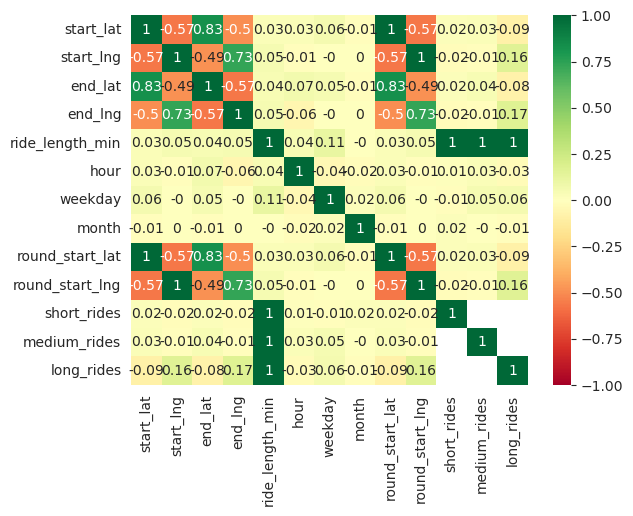

In [23]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, cmap="RdYlGn", vmin=-1, vmax=1)
    plt.show()

The heatmap and correlation table do not reveal any strong relationships between variables that wouldn't have been expected - start and end latitudes and longitudes are naturally correlated as people don't go as far by bike. All other variables do not seem to systematically correlate.
Now, let's dive into the project question and examine different behaviors of casual riders and members.

<h2>Analysis: Comparing members and casual riders, focus on time aspects </h2>
In this section, data is analyzed to answer the leading project question. First, time variables are considered, followed by the bike type and an additional geospatial analysis. 

<h3>Ride length</h3>
The table below shows mean values of the ride length per membership status.

In [24]:
df[['ride_length_min', 'short_rides', 'medium_rides', 'long_rides']].groupby(df['member_casual']).mean().round(2)

ride_length_min  short_rides  medium_rides  long_rides
member_casual                                                        
casual                   29.21         3.88         12.02       63.39
member                   12.93         3.86         11.27       35.23

Looking at the numbers, members mainly seem to take less long rides than non-members. Let's back it up by statistics and visualization for all four subcategories - global ride length, short rides shorter than 6 minutes, medium rides, and long rides longer than 20 minutes.

In [25]:
df[['ride_length_min']].groupby(df['member_casual']).mean().reset_index()

member_casual  ride_length_min
0        casual        29.212621
1        member        12.932889

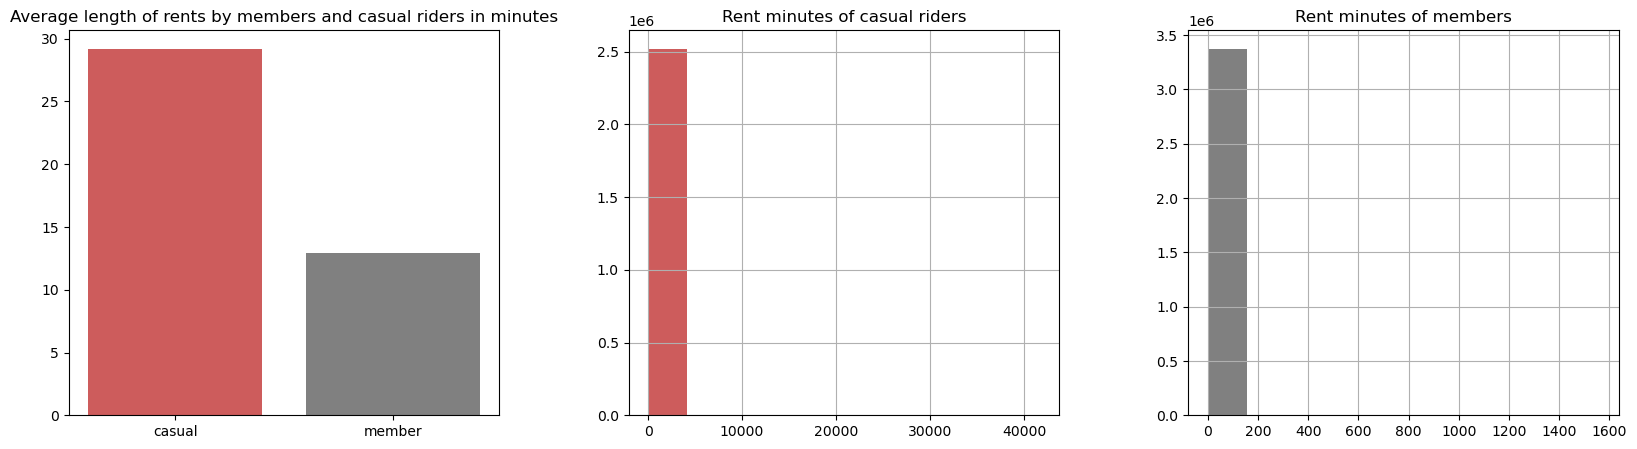

MannwhitneyuResult(statistic=2923851693636.5, pvalue=0.0)

In [26]:
#Overall ride length
fig = plt.figure()
fig.set_size_inches(20, 5)
ax0 = fig.add_subplot(131)
df1=df[['ride_length_min']].groupby(df['member_casual']).mean().reset_index()
ax0.bar(df1['member_casual'], df1['ride_length_min'], color=['indianred', 'grey'])
plt.title('Average length of rents by members and casual riders in minutes')
ax1=fig.add_subplot(132)
df[['ride_length_min']][df['member_casual'] == 'casual'].hist(ax=ax1, color=['indianred'])
plt.title('Rent minutes of casual riders')
ax2=fig.add_subplot(133)
df[['ride_length_min']][df['member_casual'] == 'member'].hist(ax=ax2, color=['grey'])
plt.title('Rent minutes of members')
plt.show()

#Mann-Whitney-U-test
mannwhitneyu(df['ride_length_min'][df['member_casual'] == 'member'], df['ride_length_min'][df['member_casual'] == 'casual'])

The plots show that on average, rents by casual riders are more than double as long as rents by members on average.
As the ride length is not normally distributed in both groups (see sanity checks above; Data is not linear for the theoretical quantiles), a Mann-Whitney-U-Test is performed next. This is the equivalent for an unpaired t-test for nonparametric data.
Considering the overall duration of rents, **rents by non-members are indeed significantly longer**. This will be further examined for the categories of short, medium and long-term rents. 

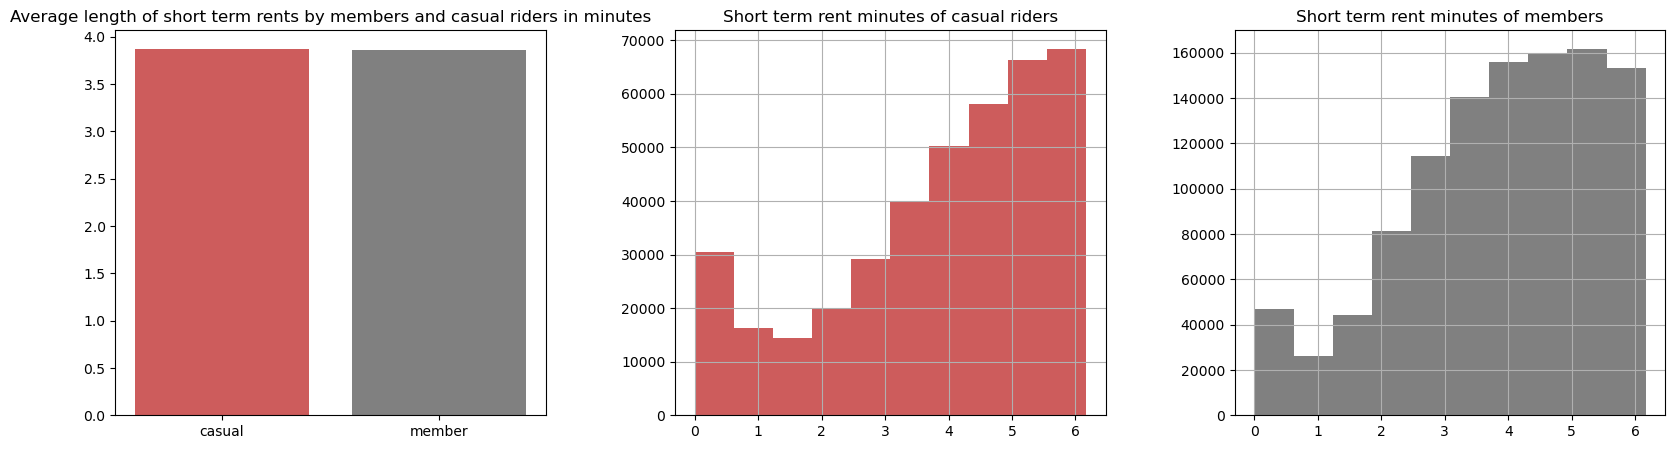

Test statistic: 205055185458.5 , p value: 0.0


In [27]:
#Short rides
fig = plt.figure()
fig.set_size_inches(20, 5)
ax0 = fig.add_subplot(131)
df1 = df[['short_rides']].groupby(df['member_casual']).mean().reset_index()
ax0.bar(df1['member_casual'], df1['short_rides'], color=['indianred', 'grey'])
plt.title('Average length of short term rents by members and casual riders in minutes')
ax1=fig.add_subplot(132)
df[['short_rides']][df['member_casual'] == 'casual'].hist(ax=ax1, color=['indianred'])
plt.title('Short term rent minutes of casual riders')
ax2=fig.add_subplot(133)
df[['short_rides']][df['member_casual'] == 'member'].hist(ax=ax2, color=['grey'])
plt.title('Short term rent minutes of members')
plt.show()

#Mann-Whitney-U-test
df1=df.loc[df['short_rides'] >= 0]
statistic, p = mannwhitneyu(df1['short_rides'][df1['member_casual'] == 'member'], df1['short_rides'][df1['member_casual'] == 'casual'])
print("Test statistic:", round(statistic,1),", p value:", round(p, 2))

For short rides, the mean length of ride minutes does not really differ between casual and member riders. However, both groups differ significantly. As the histograms reveal, members take significantly shorter rides than casual riders in the short term rent domain.

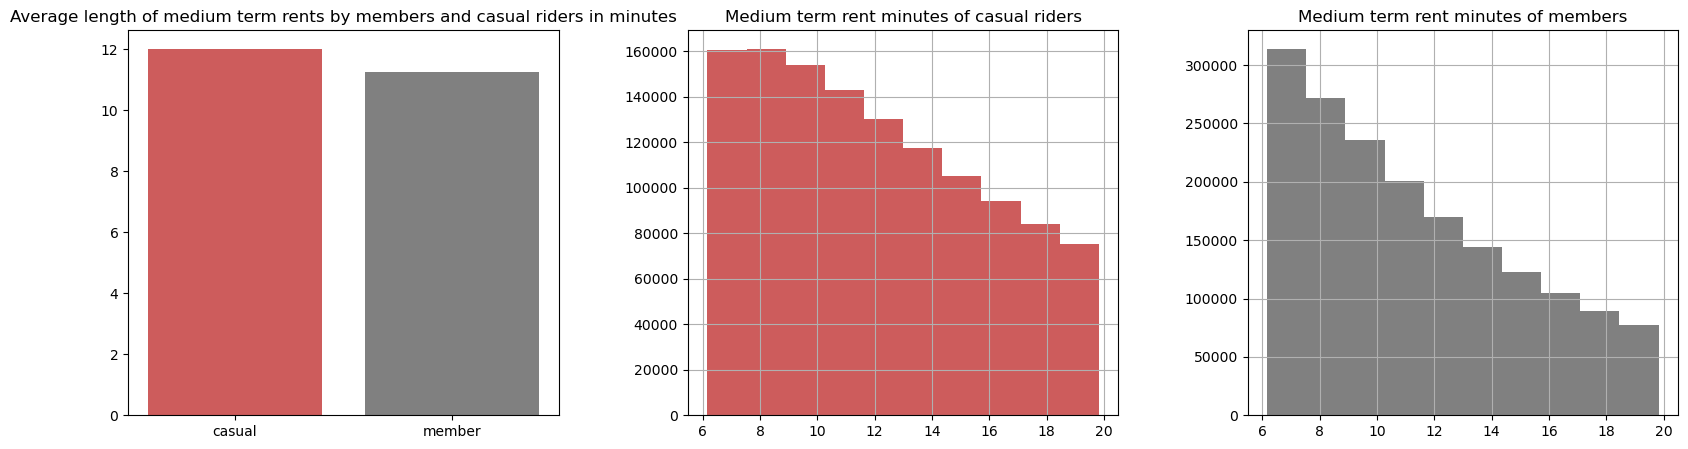

Test statistic: 935019027555.5 , p value: 0.0


In [28]:
#Medium rides
fig = plt.figure()
fig.set_size_inches(20, 5)
ax0 = fig.add_subplot(131)
df1 = df[['medium_rides']].groupby(df['member_casual']).mean().reset_index()
ax0.bar(df1['member_casual'], df1['medium_rides'], color=['indianred', 'grey'])
plt.title('Average length of medium term rents by members and casual riders in minutes')
ax1=fig.add_subplot(132)
df[['medium_rides']][df['member_casual'] == 'casual'].hist(ax=ax1, color=['indianred'])
plt.title('Medium term rent minutes of casual riders')
ax2=fig.add_subplot(133)
df[['medium_rides']][df['member_casual'] == 'member'].hist(ax=ax2, color=['grey'])
plt.title('Medium term rent minutes of members')
plt.show()

#Mann-Whitney-U-test
df1=df.loc[df['medium_rides'] >= 0]
statistic, p = mannwhitneyu(df1['medium_rides'][df1['member_casual'] == 'member'], df1['medium_rides'][df1['member_casual'] == 'casual'])
print("Test statistic:", round(statistic,1),", p value:", round(p, 2))

In this category, too, members take significantly shorter rides than non-members.

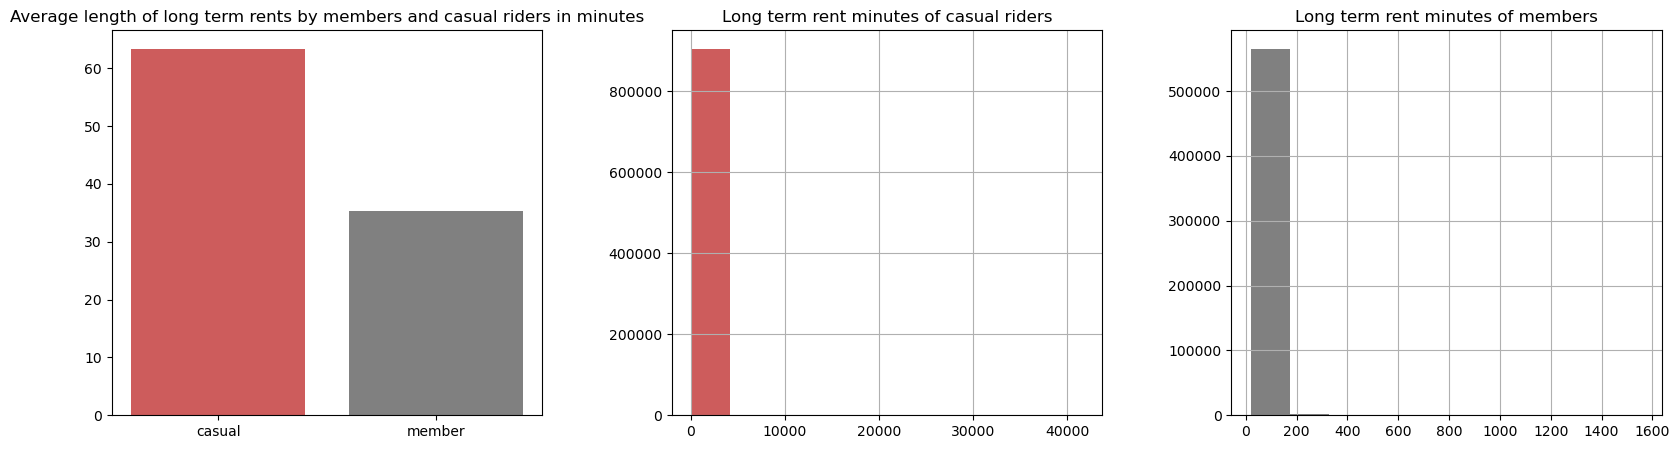

Test statistic: 189280646851.5 , p value: 0.0


In [29]:
#Long rides
fig = plt.figure()
fig.set_size_inches(20, 5)
ax0 = fig.add_subplot(131)
df1 = df[['long_rides']].groupby(df['member_casual']).mean().reset_index()
ax0.bar(df1['member_casual'], df1['long_rides'], color=['indianred', 'grey'])
plt.title('Average length of long term rents by members and casual riders in minutes')
ax1=fig.add_subplot(132)
df[['long_rides']][df['member_casual'] == 'casual'].hist(ax=ax1, color=['indianred'])
plt.title('Long term rent minutes of casual riders')
ax2=fig.add_subplot(133)
df[['long_rides']][df['member_casual'] == 'member'].hist(ax=ax2, color=['grey'])
plt.title('Long term rent minutes of members')
plt.show()

#Mann-Whitney-U-test
df1=df.loc[df['long_rides'] >= 0]
statistic, p = mannwhitneyu(df1['long_rides'][df1['member_casual'] == 'member'], df1['long_rides'][df1['member_casual'] == 'casual'])
print("Test statistic:", round(statistic,1),", p value:", round(p, 2))

In this category, it is most noticeable that members rent shorter on average.
Knowing that rents by members are shorter, the **amount** of rides in each category will now be examined using a Person's Chi Square test to not only check the distribution of rental minutes, but also the amount of rents. All assumptions of this test are met.

In [30]:
#computing contingency table
cont_cat = df[['short_rides', 'medium_rides', 'long_rides']].groupby(df['member_casual']).count()
display(cont_cat)

#computing test statistic
stat, p, dof, expected = chi2_contingency(cont_cat)
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0) - the variables have a significant relation')
else:
    print('Independent (H0 holds true)')

short_rides  medium_rides  long_rides
member_casual                                       
casual              393265       1225376      906379
member             1084251       1730451      569538

p value is 0.0
Dependent (reject H0) - the variables have a significant relation


The Chi Square test reveals that the ride-length categories are indeed differently distributed among members and casual riders. The following visualization facilitates a better understanding:

Text(0.5, 1.0, 'Amount of rents per category')

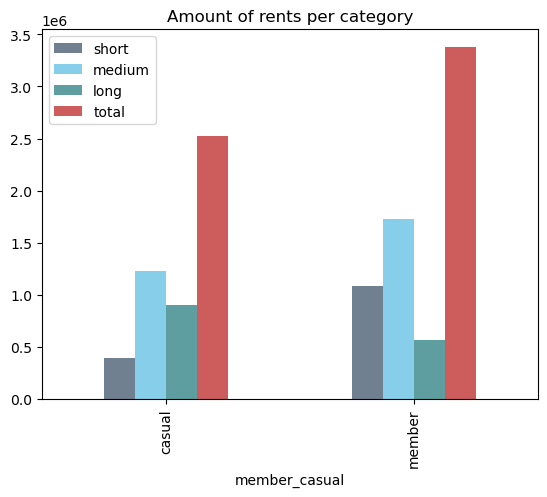

In [31]:
df[['short_rides', 'medium_rides', 'long_rides', 'ride_length_min']].groupby(df['member_casual']).count().plot(kind='bar', 
                                                                                                               color=['slategrey', 'skyblue', 'cadetblue', 'indianred'])
plt.legend(loc="upper left", labels=['short','medium','long','total'])
plt.title('Amount of rents per category')

This bar chart confirms what we already knew; Members have particularly few long-term rentals and particularly many short-term rentals compared to the number of total rentals

<h3>Time of day</h3>

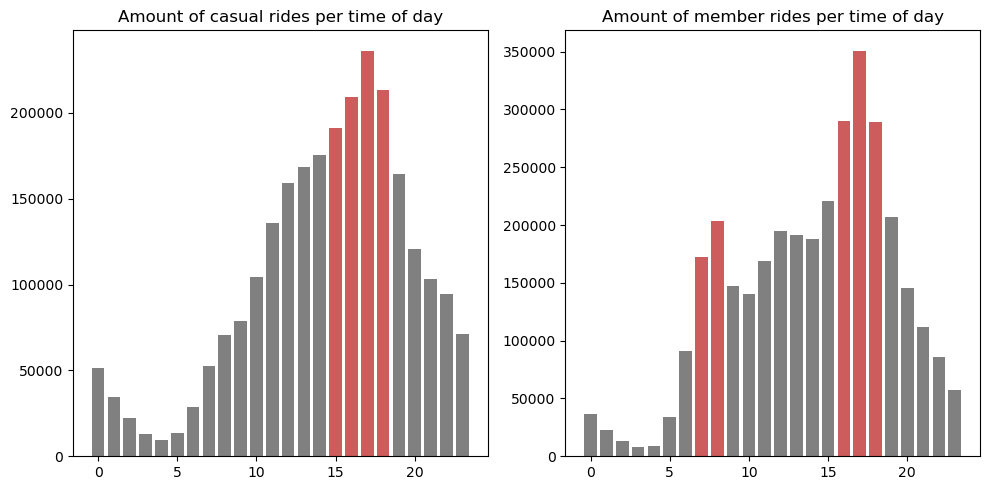

Independent t-test       results
0  Difference (Member - Casual) =  -5.467000e-01
1            Degrees of freedom =   5.901460e+06
2                             t =  -1.306325e+02
3         Two side test p value =   0.000000e+00

In [32]:
fig = plt.figure()
fig.set_size_inches(10,5)
ax0 = fig.add_subplot(121)
df1=df[['hour','ride_length_min']][df['member_casual']=='casual'].groupby(['hour']).count().reset_index()
ax0.bar(df1['hour'], df1['ride_length_min'], color=['grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','indianred','indianred','indianred','indianred',
                                                    'grey','grey','grey','grey','grey'])
plt.title('Amount of casual rides per time of day')

ax1= fig.add_subplot(122)
df1=df[['hour','ride_length_min']][df['member_casual']=='member'].groupby(['hour']).count().reset_index()
ax1.bar(df1['hour'], df1['ride_length_min'], color=['grey','grey','grey','grey','grey','grey','grey','indianred','indianred','grey','grey','grey','grey','grey','grey','grey','indianred','indianred','indianred','grey',
                                                    'grey','grey','grey','grey'])
plt.title('Amount of member rides per time of day')

fig.tight_layout()
plt.show()

#unpaired t-test
summary, results = rp.ttest(group1= df['hour'][df['member_casual'] == 'member'], group1_name= "Member",
                            group2= df['hour'][df['member_casual'] == 'casual'], group2_name= "Casual")
display(results.iloc[0:4])

Again, the distribution of member and casual riders differs significantly. As the variables are approximately normally distributed in both groups, an unpaired t-test was performed. Member rides show a small peak at the morning rush hour (7 to 9 am) and a strong peak in the afternoon (4 to 7pm), while casual rides steadily increase across the day and peak between 3 and 7 pm. The plot above shows amount of rents. Average length of rents will be examined next.

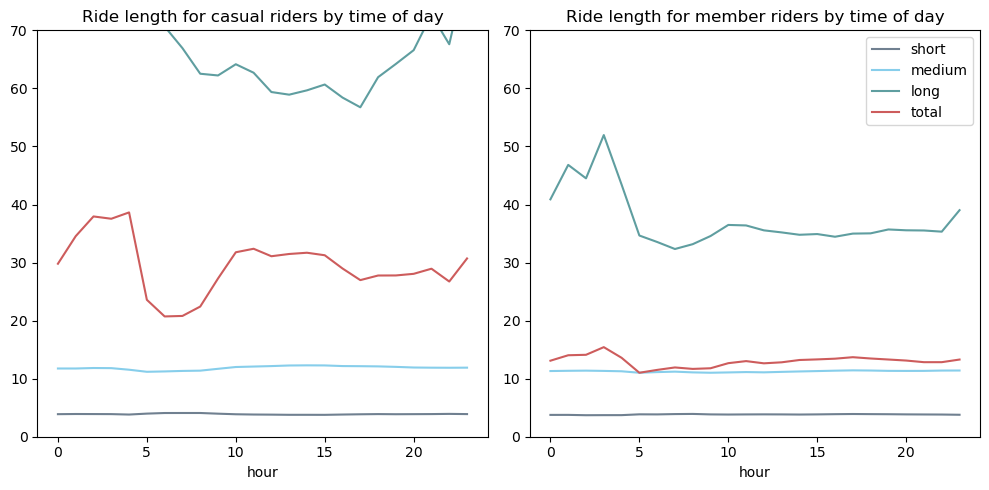

In [33]:
#Average ride length for members and casual riders by time of day
fig=plt.figure()
fig.set_size_inches(10,5)
ax0=fig.add_subplot(121)
df[['member_casual', 'hour', 'short_rides', 'medium_rides', 'long_rides', 'ride_length_min']][df['member_casual']=='casual'].groupby(['hour']).mean().plot(
    kind='line', color=['slategrey', 'skyblue', 'cadetblue', 'indianred'], ax=ax0)
plt.title('Ride length for casual riders by time of day')
ax0.get_legend().remove()
plt.ylim([0,70])

ax1=fig.add_subplot(122)
df[['member_casual', 'hour', 'short_rides', 'medium_rides', 'long_rides', 'ride_length_min']][df['member_casual']=='member'].groupby(['hour']).mean().plot(
    kind='line', color=['slategrey', 'skyblue', 'cadetblue', 'indianred'], ax=ax1)
plt.legend(labels=['short','medium','long','total'], loc='upper right')
plt.title('Ride length for member riders by time of day')
plt.ylim([0,70])
fig.tight_layout()
plt.show()

In [34]:
#Kruskal-Wallis-test casual riders
df1=df[['hour', 'ride_length_min']][df['member_casual']=='casual'].pivot(columns='hour', values='ride_length_min')
df1[0].fillna(df1[0].mean(), inplace=True)
df1[1].fillna(df1[1].mean(), inplace=True)
df1[2].fillna(df1[2].mean(), inplace=True)
df1[3].fillna(df1[3].mean(), inplace=True)
df1[4].fillna(df1[4].mean(), inplace=True)
df1[5].fillna(df1[5].mean(), inplace=True)
df1[6].fillna(df1[6].mean(), inplace=True)
df1[7].fillna(df1[7].mean(), inplace=True)
df1[8].fillna(df1[8].mean(), inplace=True)
df1[9].fillna(df1[9].mean(), inplace=True)
df1[10].fillna(df1[10].mean(), inplace=True)
df1[11].fillna(df1[11].mean(), inplace=True)
df1[12].fillna(df1[12].mean(), inplace=True)
df1[13].fillna(df1[13].mean(), inplace=True)
df1[14].fillna(df1[14].mean(), inplace=True)
df1[15].fillna(df1[15].mean(), inplace=True)
df1[16].fillna(df1[16].mean(), inplace=True)
df1[17].fillna(df1[17].mean(), inplace=True)
df1[18].fillna(df1[18].mean(), inplace=True)
df1[19].fillna(df1[19].mean(), inplace=True)
df1[20].fillna(df1[20].mean(), inplace=True)
df1[21].fillna(df1[21].mean(), inplace=True)
df1[22].fillna(df1[22].mean(), inplace=True)
df1[23].fillna(df1[23].mean(), inplace=True)

stats.kruskal(df1[0], df1[1], df1[2], df1[3], df1[4], df1[5], df1[6], df1[7], df1[8], df1[9], df1[10], df1[11], df1[12],
             df1[13], df1[14], df1[15], df1[16], df1[17], df1[18], df1[19], df1[20], df1[21], df1[22], df1[23])

KruskalResult(statistic=53495134.53637219, pvalue=0.0)

In [35]:
#Kruskal-Wallis-test members
df1=df[['hour', 'ride_length_min']][df['member_casual']=='member'].pivot(columns='hour', values='ride_length_min')
df1[0].fillna(df1[0].mean(), inplace=True)
df1[1].fillna(df1[1].mean(), inplace=True)
df1[2].fillna(df1[2].mean(), inplace=True)
df1[3].fillna(df1[3].mean(), inplace=True)
df1[4].fillna(df1[4].mean(), inplace=True)
df1[5].fillna(df1[5].mean(), inplace=True)
df1[6].fillna(df1[6].mean(), inplace=True)
df1[7].fillna(df1[7].mean(), inplace=True)
df1[8].fillna(df1[8].mean(), inplace=True)
df1[9].fillna(df1[9].mean(), inplace=True)
df1[10].fillna(df1[10].mean(), inplace=True)
df1[11].fillna(df1[11].mean(), inplace=True)
df1[12].fillna(df1[12].mean(), inplace=True)
df1[13].fillna(df1[13].mean(), inplace=True)
df1[14].fillna(df1[14].mean(), inplace=True)
df1[15].fillna(df1[15].mean(), inplace=True)
df1[16].fillna(df1[16].mean(), inplace=True)
df1[17].fillna(df1[17].mean(), inplace=True)
df1[18].fillna(df1[18].mean(), inplace=True)
df1[19].fillna(df1[19].mean(), inplace=True)
df1[20].fillna(df1[20].mean(), inplace=True)
df1[21].fillna(df1[21].mean(), inplace=True)
df1[22].fillna(df1[22].mean(), inplace=True)
df1[23].fillna(df1[23].mean(), inplace=True)

stats.kruskal(df1[0], df1[1], df1[2], df1[3], df1[4], df1[5], df1[6], df1[7], df1[8], df1[9], df1[10], df1[11], df1[12],
             df1[13], df1[14], df1[15], df1[16], df1[17], df1[18], df1[19], df1[20], df1[21], df1[22], df1[23])

KruskalResult(statistic=70213661.56432353, pvalue=0.0)

This uneven distribution of ride lengths across the day is statistically significant for both groups - They don't ride equally long at all times of day. Rents in the early morning tend to be longer. Especially for casual riders, rides between 5 and 10am are shorter compared to other times of day.
Next, an analysis of rides depending on weekdays is performed.

<h3>Weekdays</h3>

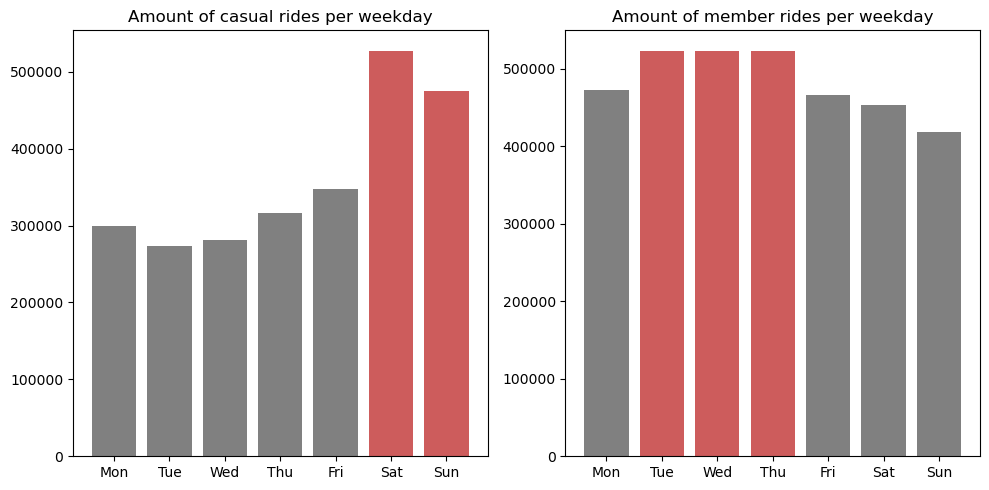

Test statistic: 3593364632746.0 , p value: 0.0


In [36]:
fig = plt.figure()
fig.set_size_inches(10,5)
ax0 = fig.add_subplot(121)
df1=df[['weekday','ride_length_min']][df['member_casual']=='casual'].groupby(['weekday']).count().reset_index()
ax0.bar(df1['weekday'], df1['ride_length_min'], color=['grey', 'grey', 'grey', 'grey', 'grey', 'indianred', 'indianred'])
ax0.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax0.xaxis.set(ticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Amount of casual rides per weekday')

ax1= fig.add_subplot(122)
df1=df[['weekday','ride_length_min']][df['member_casual']=='member'].groupby(['weekday']).count().reset_index()
ax1.bar(df1['weekday'], df1['ride_length_min'], color=['grey', 'indianred', 'indianred', 'indianred', 'grey', 'grey', 'grey'])
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax1.xaxis.set(ticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Amount of member rides per weekday')

fig.tight_layout()
plt.show()

#Mann-Whitney-U-test
statistic, p = mannwhitneyu(df['weekday'][df['member_casual'] == 'member'], df['weekday'][df['member_casual'] == 'casual'])
print("Test statistic:", round(statistic,1),", p value:", round(p, 2))

This indicates that casual riders mainly rent bikes on weekends (propably mainly for recreational purposes) while members mainly rent bikes during the week (propably mainly for commuting). The Mann-Whitney-U-test confirms that both groups rent differently across the week. The plots above depict the amount of rents.
In the visualization below, the average length of rents per weekday will be determined.

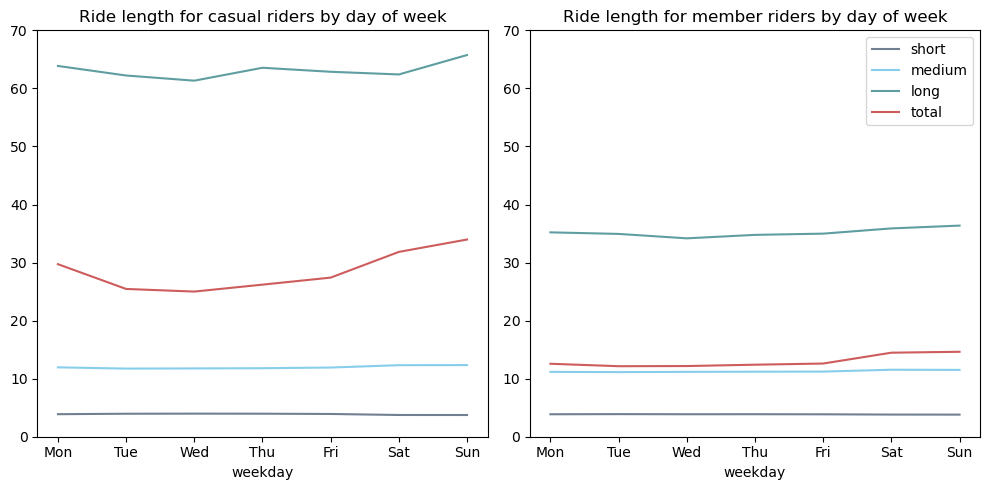

In [37]:
#Average ride length for members and casual riders by day of week
fig=plt.figure()
fig.set_size_inches(10,5)
ax0=fig.add_subplot(121)
df[['member_casual', 'weekday', 'short_rides', 'medium_rides', 'long_rides', 'ride_length_min']][df['member_casual']=='casual'].groupby(['weekday']).mean().plot(
    kind='line', color=['slategrey', 'skyblue', 'cadetblue', 'indianred'], ax=ax0)
plt.title('Ride length for casual riders by day of week')
ax0.get_legend().remove()
plt.ylim([0,70])
ax0.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax0.xaxis.set(ticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax1=fig.add_subplot(122)
df[['member_casual', 'weekday', 'short_rides', 'medium_rides', 'long_rides', 'ride_length_min']][df['member_casual']=='member'].groupby(['weekday']).mean().plot(
    kind='line', color=['slategrey', 'skyblue', 'cadetblue', 'indianred'], ax=ax1)
plt.legend(labels=['short','medium','long','total'], loc='upper right')
plt.title('Ride length for member riders by day of week')
plt.ylim([0,70])
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax1.xaxis.set(ticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
fig.tight_layout()
plt.show()

Even though members rent more frequently during weekdays, the average ride length is longer on weekends, both for casual and member riders. Following up, two Kruskal-Wallis-tests (nonparametric version of ANOVA) will be performed to test whether the ride length is significantly longer on weekends, both for member and casual riders.

In [38]:
#Kruskal-Wallis-test casual riders
df1=df[['weekday', 'ride_length_min']][df['member_casual']=='casual'].pivot(columns='weekday', values='ride_length_min')
df1[0].fillna(df1[0].mean(), inplace=True)
df1[1].fillna(df1[1].mean(), inplace=True)
df1[2].fillna(df1[2].mean(), inplace=True)
df1[3].fillna(df1[3].mean(), inplace=True)
df1[4].fillna(df1[4].mean(), inplace=True)
df1[5].fillna(df1[5].mean(), inplace=True)
df1[6].fillna(df1[6].mean(), inplace=True)
stats.kruskal(df1[0], df1[1], df1[2], df1[3], df1[4], df1[5], df1[6])

KruskalResult(statistic=9520147.213013094, pvalue=0.0)

In [39]:
#Kruskal-Wallis-test member riders
df1=df[['weekday', 'ride_length_min']][df['member_casual']=='member'].pivot(columns='weekday', values='ride_length_min')
df1[0].fillna(df1[0].mean(), inplace=True)
df1[1].fillna(df1[1].mean(), inplace=True)
df1[2].fillna(df1[2].mean(), inplace=True)
df1[3].fillna(df1[3].mean(), inplace=True)
df1[4].fillna(df1[4].mean(), inplace=True)
df1[5].fillna(df1[5].mean(), inplace=True)
df1[6].fillna(df1[6].mean(), inplace=True)
stats.kruskal(df1[0], df1[1], df1[2], df1[3], df1[4], df1[5], df1[6])

KruskalResult(statistic=13840434.132392252, pvalue=0.0)

For both groups, average ride length significantly differs across weekdays. As shown in the plots above, average rides on weekends are longer for both groups.

<h3>Months</h3>

Next, different renting behavior of members and casual riders during the different seasons is examined.

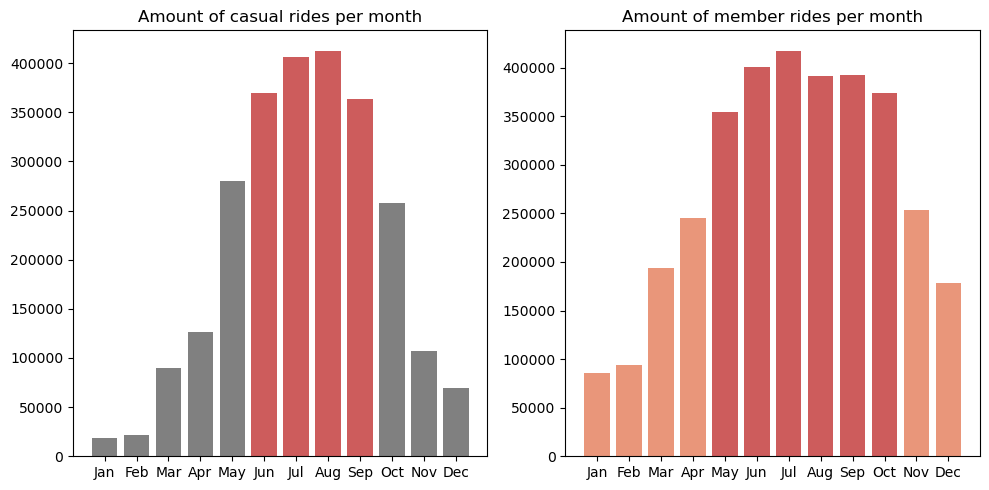

In [40]:
fig = plt.figure()
fig.set_size_inches(10,5)
ax0 = fig.add_subplot(121)
df1=df[['month','ride_length_min']][df['member_casual']=='casual'].groupby(['month']).count().reset_index()
ax0.bar(df1['month'], df1['ride_length_min'], color=['grey', 'grey', 'grey', 'grey', 'grey', 'indianred', 'indianred', 'indianred', 'indianred', 'grey', 'grey', 'grey'])
ax0.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax0.xaxis.set(ticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Amount of casual rides per month')

ax1= fig.add_subplot(122)
df1=df[['month','ride_length_min']][df['member_casual']=='member'].groupby(['month']).count().reset_index()
ax1.bar(df1['month'], df1['ride_length_min'], color=['darksalmon', 'darksalmon', 'darksalmon', 'darksalmon', 'indianred', 'indianred', 'indianred', 'indianred', 'indianred', 'indianred', 'darksalmon', 'darksalmon'])
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.xaxis.set(ticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Amount of member rides per month')

fig.tight_layout()
plt.show()

The curve of member rent frequency is wider than that of casual riders. Casual riders mainly rent during summer months (Jun - Sep), while members also rent more frequently during spring and autumn.
Since summer rental occupancy is not a problem, the following unpaired t-test text is calculated to check whether one of the groups rents significantly more often in winter. A t-test is used as the plots show approximately normaly distributed variables.

In [41]:
#unpaired t-test
summary, results = rp.ttest(group1= df['month'][df['member_casual'] == 'member'], group1_name= "Member",
                            group2= df['month'][df['member_casual'] == 'casual'], group2_name= "Casual")
display(results.iloc[0:4])

Independent t-test       results
0  Difference (Member - Casual) =  -1.413000e-01
1            Degrees of freedom =   5.901460e+06
2                             t =  -6.611740e+01
3         Two side test p value =   0.000000e+00

The distribution of rents over the year significantly differs for member and casual riders. The following more global Chi Square test and plot facilitate an easier interpretation:

month           winter   summer
member_casual                  
casual          563726  1958499
member         1178438  2200799

p value is 0.0
Dependent (reject H0) - the variables have a significant relation


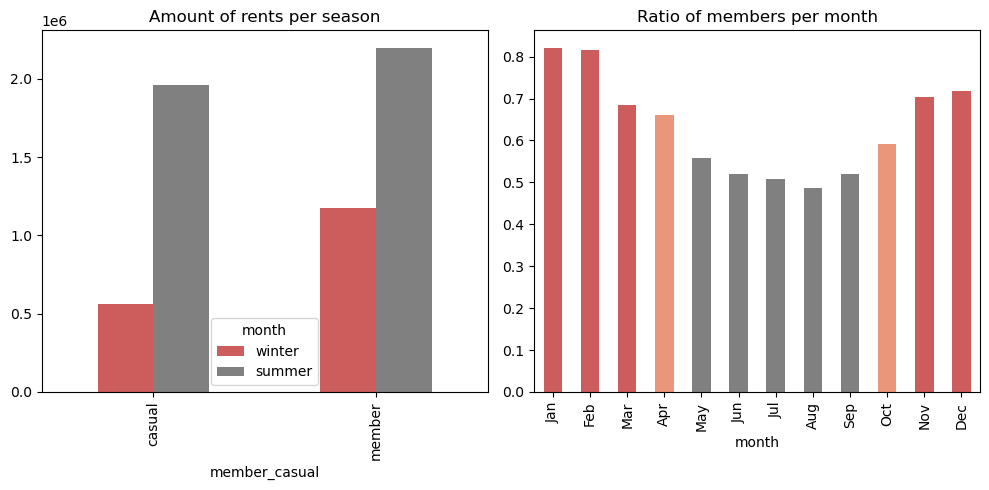

In [42]:
#Contingency table
seasons=df[['ride_length_min','month','member_casual']].groupby(['member_casual','month']).count().rename(columns={'ride_length_min':'frequency'}).reset_index().set_index('member_casual')
seasons=seasons.pivot(columns='month',values='frequency').reset_index()
winter1=seasons.set_index('member_casual')
winter2=winter1.transpose()
winter2['member_ratio']=winter2['member']/(winter2['member']+winter2['casual'])
seasons['winter']=seasons[[1, 2, 3, 10, 11, 12]].sum(axis=1)
seasons['summer']=seasons[[4, 5, 6,7,8,9]].sum(axis=1)
seasons.drop(columns=[1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)
seasons.set_index('member_casual', inplace=True)
display(seasons)

#Computing test statistic
stat, p, dof, expected = chi2_contingency(seasons)
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0) - the variables have a significant relation')
else:
    print('Independent (H0 holds true)')
    
#Figure    
fig=plt.figure()
fig.set_size_inches(10,5)
ax0=fig.add_subplot(121)
seasons.plot(kind='bar', color=['indianred', 'grey'], ax=ax0)
plt.title('Amount of rents per season')
ax1=fig.add_subplot(122)
winter2=winter1.transpose()
winter2['member_ratio']=winter2['member']/(winter2['member']+winter2['casual'])
winter2['member_ratio'].plot(kind='bar', color=['indianred', 'indianred', 'indianred', 'darksalmon', 'grey', 'grey', 'grey', 'grey', 'grey', 'darksalmon', 'indianred', 'indianred'], ax=ax1)
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax1.xaxis.set(ticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Ratio of members per month')
fig.tight_layout()
plt.show()

These figures show it quite impressively: Especially in winter months, members rent (significantly) more often than casual riders. E.g., in January, and February, more than 80% of rents are made by members.
The plots above again surveyed the amount of rents. Below, the average length of rents over the year is examined.

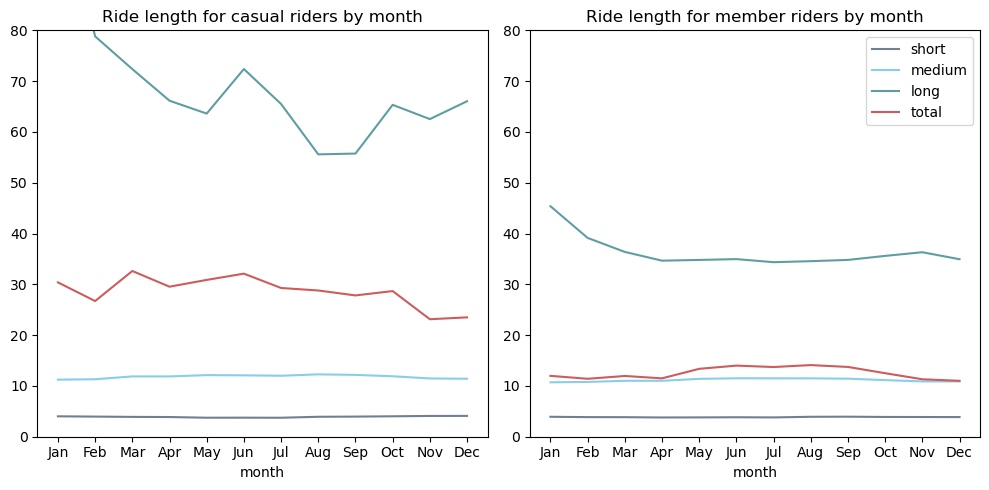

In [43]:
#Average ride length for members and casual riders by month
fig=plt.figure()
fig.set_size_inches(10,5)
ax0=fig.add_subplot(121)
df[['member_casual', 'month', 'short_rides', 'medium_rides', 'long_rides', 'ride_length_min']][df['member_casual']=='casual'].groupby(['month']).mean().plot(
    kind='line', color=['slategrey', 'skyblue', 'cadetblue', 'indianred'], ax=ax0)
plt.title('Ride length for casual riders by month')
ax0.get_legend().remove()
plt.ylim([0,80])
ax0.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax0.xaxis.set(ticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ax1=fig.add_subplot(122)
df[['member_casual', 'month', 'short_rides', 'medium_rides', 'long_rides', 'ride_length_min']][df['member_casual']=='member'].groupby(['month']).mean().plot(
    kind='line', color=['slategrey', 'skyblue', 'cadetblue', 'indianred'], ax=ax1)
plt.legend(labels=['short','medium','long','total'], loc='upper right')
plt.title('Ride length for member riders by month')
plt.ylim([0,80])
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.xaxis.set(ticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
fig.tight_layout()
plt.show()

This curve is quite surprising - as expected, mean rent time is slightly longer during summer months for both, members and casual riders. However, both long rent curves peak in January. Perhaps renters are too impatient when it's cold and don't wait for the lease to end, allowing mistakes to happen and rents to continue when they should be terminated?

In [44]:
#Kruskal-Wallis-test casual riders
df1=df[['month', 'ride_length_min']][df['member_casual']=='casual'].pivot(columns='month', values='ride_length_min')
df1[1].fillna(df1[1].mean(), inplace=True)
df1[2].fillna(df1[2].mean(), inplace=True)
df1[3].fillna(df1[3].mean(), inplace=True)
df1[4].fillna(df1[4].mean(), inplace=True)
df1[5].fillna(df1[5].mean(), inplace=True)
df1[6].fillna(df1[6].mean(), inplace=True)
df1[7].fillna(df1[7].mean(), inplace=True)
df1[8].fillna(df1[8].mean(), inplace=True)
df1[9].fillna(df1[9].mean(), inplace=True)
df1[10].fillna(df1[10].mean(), inplace=True)
df1[11].fillna(df1[11].mean(), inplace=True)
df1[12].fillna(df1[12].mean(), inplace=True)
stats.kruskal(df1[1], df1[2], df1[3], df1[4], df1[5], df1[6], df1[7], df1[8], df1[9], df1[10], df1[11], df1[12])

KruskalResult(statistic=22081591.77716542, pvalue=0.0)

In [45]:
#Kruskal-Wallis-test member riders
df1=df[['month', 'ride_length_min']][df['member_casual']=='member'].pivot(columns='month', values='ride_length_min')
df1[1].fillna(df1[1].mean(), inplace=True)
df1[2].fillna(df1[2].mean(), inplace=True)
df1[3].fillna(df1[3].mean(), inplace=True)
df1[4].fillna(df1[4].mean(), inplace=True)
df1[5].fillna(df1[5].mean(), inplace=True)
df1[6].fillna(df1[6].mean(), inplace=True)
df1[7].fillna(df1[7].mean(), inplace=True)
df1[8].fillna(df1[8].mean(), inplace=True)
df1[9].fillna(df1[9].mean(), inplace=True)
df1[10].fillna(df1[10].mean(), inplace=True)
df1[11].fillna(df1[11].mean(), inplace=True)
df1[12].fillna(df1[12].mean(), inplace=True)
stats.kruskal(df1[1], df1[2], df1[3], df1[4], df1[5], df1[6], df1[7], df1[8], df1[9], df1[10], df1[11], df1[12])

KruskalResult(statistic=29108692.969542053, pvalue=0.0)

Once again, the uneven distribution of mean ride length across the year is significant for both groups, member and casual riders.

<h2>Bike type</h2>
The following section examines the different bike types offered by the company. Do members rent different bikes than casual riders?

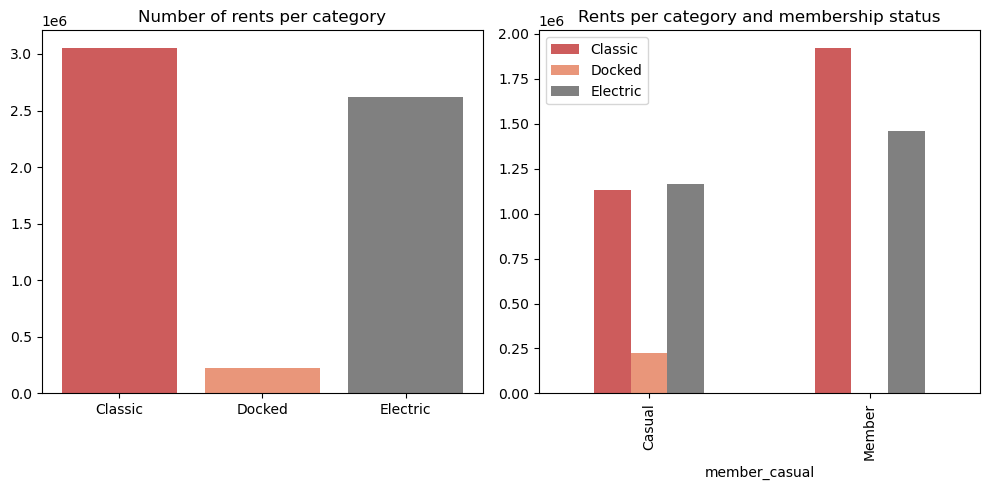

In [46]:
#generating dfs for plot
df1=df[['rideable_type', 'ride_length_min']].groupby(['rideable_type']).count().reset_index()

df2=df[['member_casual', 'rideable_type', 'ride_length_min']].groupby(['member_casual', 'rideable_type']).count().reset_index()
df2.rename(index={4:5},inplace=True)
df2.loc[4] = ['member', 'docked_bike', 0]
df2 = df2.sort_index() 
df2=df2.groupby(by=['member_casual', 'rideable_type']).sum().reset_index().set_index('member_casual')
df2=df2.pivot(columns='rideable_type', values='ride_length_min')

#plotting
fig=plt.figure()
fig.set_size_inches(10,5)
ax0=fig.add_subplot(121)
ax0.bar(df1['rideable_type'], df1['ride_length_min'], color=['indianred', 'darksalmon', 'grey'])
ax0.set_xticks([0, 1, 2])
ax0.xaxis.set(ticklabels=['Classic', 'Docked', 'Electric'])
plt.title('Number of rents per category')

ax1=fig.add_subplot(122)
df2.plot(kind='bar', ax=ax1, color=['indianred', 'darksalmon', 'grey'])
plt.legend(loc="upper left", labels=['Classic','Docked','Electric'])
ax1.set_xticks([0, 1])
ax1.xaxis.set(ticklabels=['Casual', 'Member'])
plt.title('Rents per category and membership status')
plt.tight_layout()

plt.show()

Consequently, docked bikes are the least rented category while classic bikes are rented most often. This particularly seems to be the case for members. However, not a single rent event where a member rented a docked bike appeared in the data set.
To check whether members and casual riders statistically differ in the rented bike categories, a Chi Square test is performed next.

In [47]:
#Chi Square test
display(df2)

#computing test statistic
stat, p, dof, expected = chi2_contingency(df2)
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0) - the variables have a significant relation')
else:
    print('Independent (H0 holds true)')
    

rideable_type  classic_bike  docked_bike  electric_bike
member_casual                                          
casual              1132892       226728        1162605
member              1922749            0        1456488

p value is 0.0
Dependent (reject H0) - the variables have a significant relation


Once again, this Chi Square test is significant, meaning that the differences between bike category by member and casual riders outlined above are statistically proven.

Text(0.5, 1.0, 'Rents per category and month')

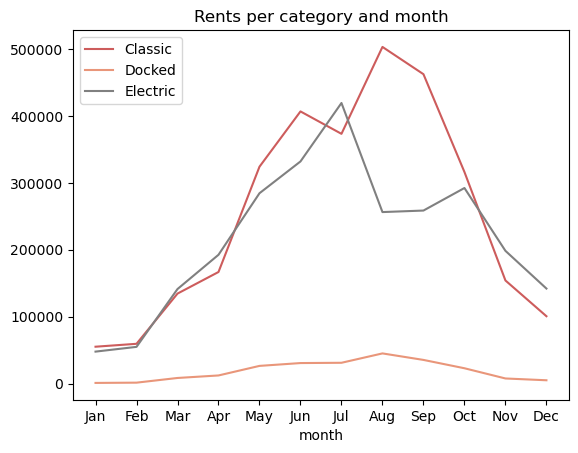

In [48]:
#bike type per season
df2=df[['month', 'rideable_type', 'ride_length_min']].groupby(['month', 'rideable_type']).count().reset_index()
df2=df2.groupby(by=['month', 'rideable_type']).sum().reset_index().set_index('month')
df2=df2.pivot(columns='rideable_type', values='ride_length_min')

df2.plot(kind='line', color=['indianred', 'darksalmon', 'grey'])
plt.legend(loc="upper left", labels=['Classic','Docked','Electric'])
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Rents per category and month')

In [49]:
display(df2)
#computing test statistic
stat, p, dof, expected = chi2_contingency(df2)
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0) - the variables have a significant relation')
else:
    print('Independent (H0 holds true)')
    

rideable_type  classic_bike  docked_bike  electric_bike
month                                                  
1                     55067          961          47741
2                     59414         1361          54834
3                    134439         8358         141245
4                    166712        12116         192421
5                    324046        26409         284403
6                    406660        30640         331904
7                    373173        31055         419260
8                    503033        45065         256254
9                    462284        35337         258526
10                   316139        22884         292203
11                   154039         7614         198325
12                   100635         4928         141977

p value is 0.0
Dependent (reject H0) - the variables have a significant relation


From October to July, classic and electric bikes were comparably popular. However, in August and September, popularity of electric bikes decreased while classic bikes reached their annual maxmimum renting frequency. Docked bikes were rented more often during summer months.

<h2>Geospatial mapping - members and casual riders</h2>

Lastly, a geospatial comparison of member and casual riders will be performed. 

In [50]:
# create a map of centered around Chicago
rent_map = folium.Map(location=[41.8, -87], zoom_start=9, tiles='CartoDB positron')

#casual riders
#creating df
df_map_c=df[['round_start_lat', 'round_start_lng','ride_length_min']][df['member_casual']=='casual'].groupby(by=['round_start_lat', 'round_start_lng']).count()
df_map_c.rename(columns={'ride_length_min':'frequency'}, inplace=True)
df_map_c.reset_index(inplace=True)

# initiate a feature group for the rents in the dataframe
rents_c = folium.map.FeatureGroup()

# loop through the rents and add each to the rents feature group
for lat, lng, size in zip(df_map_c.round_start_lat, df_map_c.round_start_lng, df_map_c.frequency):
    rents_c.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=size/4000,
            color='indianred',
            opacity=0.3,
            fill=True,
            fill_color='indianred',
            fill_opacity=0.3
        )
    )

# add rents to map
rent_map.add_child(rents_c)


#members
#creating df
df_map_m=df[['round_start_lat', 'round_start_lng','ride_length_min']][df['member_casual']=='member'].groupby(by=['round_start_lat', 'round_start_lng']).count()
df_map_m.rename(columns={'ride_length_min':'frequency'}, inplace=True)
df_map_m.reset_index(inplace=True)

# initiate a feature group for the rents in the dataframe
rents_m = folium.map.FeatureGroup()

# loop through the rents and add each to the rents feature group
for lat, lng, size in zip(df_map_m.round_start_lat, df_map_m.round_start_lng, df_map_m.frequency):
    rents_m.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=size/4000,
            color='grey',
            opacity=0.3,
            fill=True,
            fill_color='grey',
            fill_opacity=0.3
        )
    )

# add rents to map
rent_map.add_child(rents_m)

This map shows that both member and casual riders rent all over Chicago. However, member riders tend to rent a bit more in the Northside and Woodlawn suburb, while casual riders rent more bikes in the harbour area. Maybe, casual riders are mostly tourists using the bikes for exploring and sight seeing.

<h2>How do members and casual riders differ in their renting behavior?</h2>

- **Length of rides**: Members tke significantly shorter rides compared to casuals.
- **Time of day**: Rents by members peak in the morning and afternoon, while casual rents only peak in the afternoon.
- **Day of week**: Members primarily rent on weekdays, while casual riders mostly rent on weekends.
- **Months**: Both, members and casuals rent more frequently in summer months. However, during winter months members constitute 80% of customers.
- **Bike type**: Docked bikes were only rented by casual riders, members prefer classic bikes.
- **Location**: Casuals rent very often in the harbor area, while members rather also in the suburbs.

<h2>Recommendations</h2>
<h4>General:</h4>

- Perform maintanance in the mornings, not on weekends. Especially, repair larger batches in winter.
- Provide more bikes in harbour area during summer months.
- Offer more docked bikes as their rent times are longest.
- Considering taking bikes out of circulation in winter as less rented anyway and to avoid unnecessary corrosion. Here, the harbor region, which is much frequented by casual riders, is particularly suitable.


<h4>Considering leading question:</h4>

- Price long trips higher for casuals.
- In the winter months, the focus should be on offers and promotions to retain customers with membership status. Some ideas would be e.g. the dispatch of portable bicycle lamps, but also Advent raffles or similar.
- In the summer, the focus should be on attracting new members, as this is when the potential target group is largest. Billboards and other marketing campaigns, enticements, and bring a friend offers would be suitable examples. Above all, the measures should be placed in the afternoon and on weekends.